In [1]:
# Import the ns3 source script
import sys
sys.path.append("../../../ns3_sem")
import sem
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
ns_path = '../../../../ns3-dev-hofailure_RACH'
script = 'lena_hofailure'
campaign_dir = 'rngrun5'
campaign = sem.CampaignManager.new(ns_path, script, campaign_dir, overwrite=True)
print(campaign)

--- Campaign info ---
script: lena_hofailure
params: {'simTime': '50', 'nBlocks': '1', 'nMacroEnbSites': '1', 'macroUeDensity': '1e-05', 'homeEnbDeploymentRatio': '0.2', 'homeEnbActivationRatio': '0.5', 'homeUesHomeEnbRatio': '1', 'macroEnbDlEarfcn': '100', 'homeEnbDlEarfcn': '100', 'macroEnbBandwidth': '25', 'homeEnbBandwidth': '25', 'generateRem': 'false', 'epc': 'true', 'useUdp': 'true', 'outdoorUeMinSpeed': '0', 'outdoorUeMaxSpeed': '0', 'handoverAlgorithm': 'A3', 'Hysteresis': 3.0, 'TimeToTrigger': 256.0, 'ServingCellThreshold': 20.0, 'NeighbourCellOffset': 5.0, 'SrsPeriodicity': 80.0, 'epcDl': 'true', 'epcUl': 'true', 'fadingTrace': '', 'homeEnbTxPowerDbm': '20', 'interSiteDistance': '500', 'macroEnbTxPowerDbm': '46', 'nMacroEnbSitesX': '1', 'numBearersPerUe': '1', 'remRbId': '-1', 'srsPeriodicity': '80'}
HEAD: 0d7207fae798bfae12d19957687e9766f0ddbad4
Runner type: <class 'sem.parallelrunner.ParallelRunner'>
-----------


In [2]:
# Params
import numpy as np
param_combination = {'simTime':1000, 
                     'nBlocks': 4, #list([1,2,3,4,5,6,7,8,9,10]),#round(4*nBlocks*0.1)
                     'nMacroEnbSites': 1, #list([1,2,3,4,5,6,7,8,9,10]),
                     'nMacroEnbSitesX': 1,
                     'macroUeDensity': 0.00001,#1000000 [p * 0.5 for p in range(0.0001, 0.01)]
                     'homeEnbDeploymentRatio': 1.0,
                     'homeEnbActivationRatio': 1.0,
                     'homeUesHomeEnbRatio': 1.0,
                     'outdoorUeMinSpeed': 5.0,#[j * 2.0 for j in range(2.0, 10.0)]
                     'outdoorUeMaxSpeed': 5.0,
                     'handoverAlgorithm': 'A3',
                     'Hysteresis': [j * 1.0 for j in np.arange(0.0, 3.2, 0.2)],
                     'TimeToTrigger':  list([0.0, 40.0, 64.0, 80.0, 100.0, 128.0, 160.0, 256.0, 320.0, 480.0, 512.0]),
                     'SrsPeriodicity': 80,
                     'generateRem': 0,
                     'RngRun': [5]
                    }

# Running the simulation with the params
campaign.run_missing_simulations(param_combination, stop_on_errors=False)

Running simulations: 100%|████████████████████████████████████████| 176/176 [27:56:37<00:00, 571.58s/simulation]


     Hysteresis  TimeToTrigger  num_HOs  num_RLFs  num_HFJs
0           0.0            0.0       33         9        13
1           0.0           40.0       33         9        13
2           0.0           64.0       33         9        13
3           0.0           80.0       33         9        13
4           0.0          100.0       33         9        13
..          ...            ...      ...       ...       ...
171         3.0          160.0       27         9        26
172         3.0          256.0       27         9        26
173         3.0          320.0       27         9        27
174         3.0          480.0       26        10        26
175         3.0          512.0       26        10        26

[176 rows x 5 columns]


<AxesSubplot:xlabel='Hysteresis'>

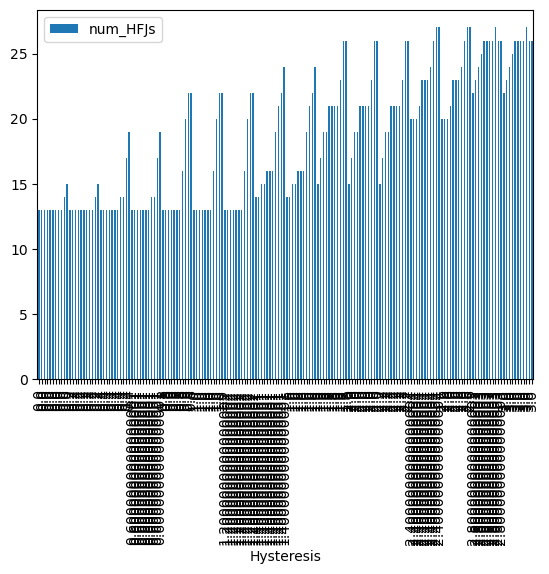

In [5]:
# Summarize the result

def get_average_throughput(result):
    if result['output']['stderr'] != "":
        num_HOs = -1
        num_RLFs = -1
        num_HFMRs = -1
        num_HFNPs = -1
        num_HFJs = -1
        num_HFLs = -1
    else:
        split_results = result['output']['stdout'].split("\n")
        num_HOs = 0
        num_RLFs = 0
        num_HFMRs = 0
        num_HFNPs = 0
        num_HFJs = 0
        num_HFLs = 0
        for line in split_results:
            event = line.split(":",1)[0]
            if event == "Handover_start":
                num_HOs += 1
            elif event == "Handover_Failure_NoPreamble":
                num_HFNPs += 1
            elif event == "Handover_Failure_JoiningTimeout":
                num_HFJs += 1
            elif event == "Handover_Failure_MaxRach":
                num_HFMRs += 1
            elif event == "Handover_Failure_LeavingTimeout":
                num_HFLs += 1
            elif event == "Radio_link_failure_detected":
                num_RLFs += 1
    return [num_HOs, num_RLFs, num_HFNPs, num_HFJs, num_HFMRs, num_HFLs]

# the result of generate dataframe

results = campaign.get_results_as_dataframe(get_average_throughput, 
                                            ['num_HOs', 'num_RLFs','num_HFNPs','num_HFJs','num_HFMRs','num_HFLs'], 
                                            params = param_combination, drop_constant_columns=True)
print(results)

# Plot the result

import pandas as pd
import numpy as np
import random

results.plot.bar('Hysteresis','num_HFJs')
